In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import Grouper
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [206]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [207]:
data = pd.read_csv('aus_production.csv')
data.head()


,Unnamed: 0,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
0,1,1956 Q1,284,5225.0,189.0,465,3923,5
1,2,1956 Q2,213,5178.0,204.0,532,4436,6
2,3,1956 Q3,227,5297.0,208.0,561,4806,7
3,4,1956 Q4,308,5681.0,197.0,570,4418,6
4,5,1957 Q1,262,5577.0,187.0,529,4339,5


In [208]:
data.shape

(218, 8)

In [209]:
df = data[['Quarter', 'Beer']]

In [210]:
df.head()

,Quarter,Beer
0,1956 Q1,284
1,1956 Q2,213
2,1956 Q3,227
3,1956 Q4,308
4,1957 Q1,262


In [211]:
# Extract year and quarter from 'Quarter' column
df[['Year', 'Quarter']] = df['Quarter'].str.split(' ', expand=True)

# Define a function to calculate the last date of each quarter
def last_date_of_quarter(year, quarter):
    if quarter == 'Q1':
        return pd.Timestamp(year, 3, 31)
    elif quarter == 'Q2':
        return pd.Timestamp(year, 6, 30)
    elif quarter == 'Q3':
        return pd.Timestamp(year, 9, 30)
    elif quarter == 'Q4':
        return pd.Timestamp(year, 12, 31)

# Apply the function to create the 'date_quarter' column
df['date_quarter'] = df.apply(lambda x: last_date_of_quarter(int(x['Year']), x['Quarter']), axis=1)

# Drop unnecessary columns
df.drop(columns=['Year', 'Quarter'], inplace=True)

# Reorder columns
df = df[['date_quarter', 'Beer']]

# Rename 'Beer' column to 'price'
df.rename(columns={'Beer': 'price'}, inplace=True)

# Displaying the transformed dataframe
df.head()


,date_quarter,price
0,1956-03-31,284
1,1956-06-30,213
2,1956-09-30,227
3,1956-12-31,308
4,1957-03-31,262


In [212]:
df.dtypes

date_quarter    datetime64[ns]
price                    int64
dtype: object

In [213]:
df.set_index('date_quarter', inplace = True)

In [214]:
df.tail()

,price
date_quarter,
2009-06-30,398
2009-09-30,419
2009-12-31,488
2010-03-31,414
2010-06-30,374


In [215]:
df.isnull().sum()

price    0
dtype: int64

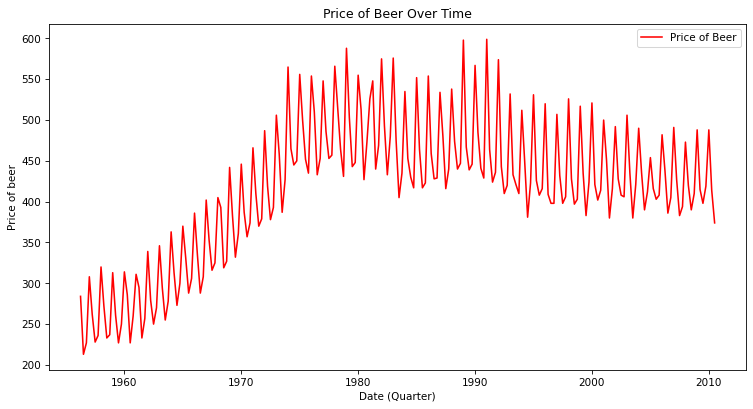

In [216]:
# Time series plot with a different color
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], color='red', label='Price of Beer')
plt.title('Price of Beer Over Time')
plt.xlabel('Date (Quarter)')
plt.ylabel('Price of beer')
plt.legend()
plt.show()


In [217]:
train1=pd.DataFrame(df[:int(0.8*len(df))])
test1=pd.DataFrame(df[int(0.8*len(df)):])

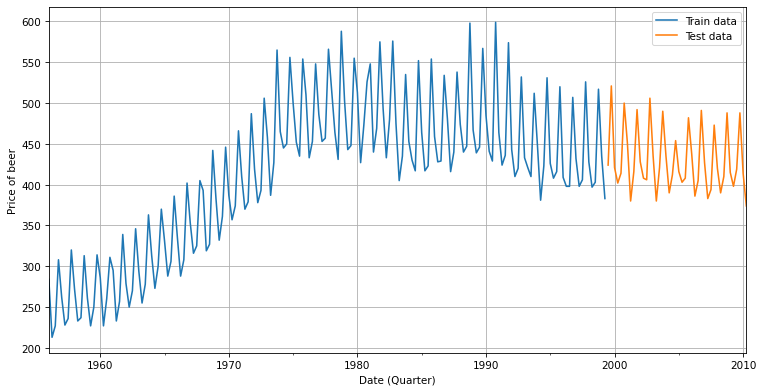

In [218]:
### Visulaise our data
fig,ax= plt.subplots(figsize=(12, 6))
train1['price'].plot(kind='line',ax =ax)
test1['price'].plot(kind='line',ax =ax)
plt.xlabel('Date (Quarter)')
plt.ylabel("Price of beer")
plt.legend(['Train data','Test data'])
plt.grid()
plt.show()

In [219]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174 entries, 1956-03-31 to 1999-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   174 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB


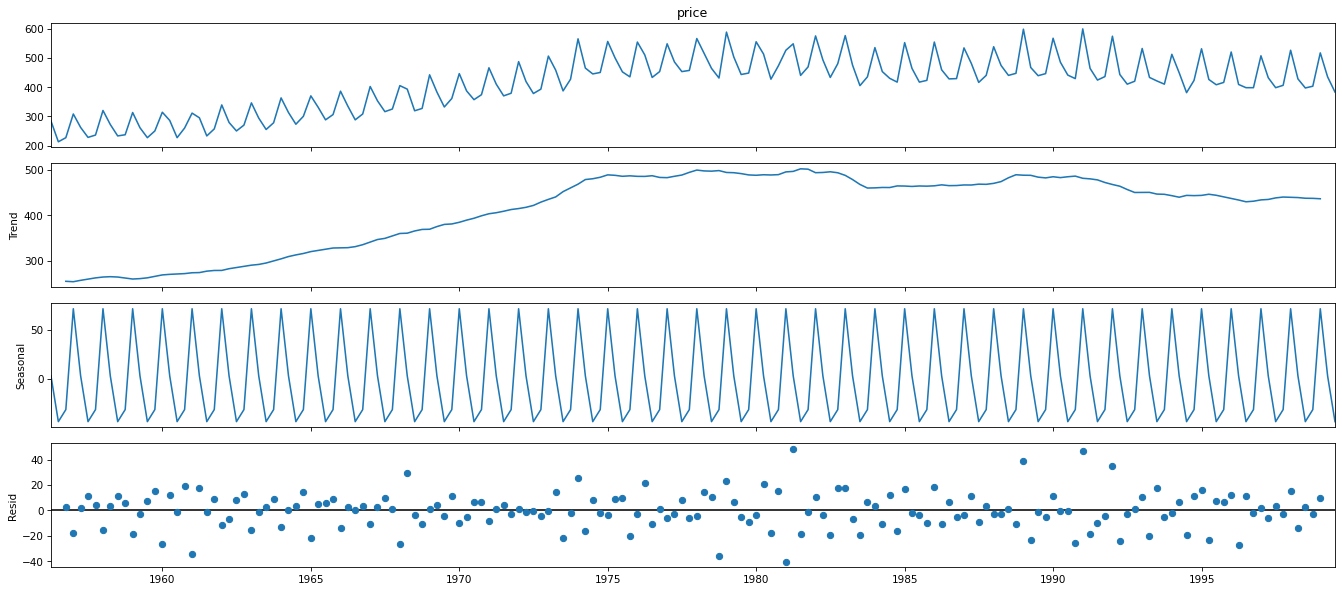

In [220]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_additive = seasonal_decompose(train1['price'],model = "additive")
s_dec_additive.plot()
plt.show()

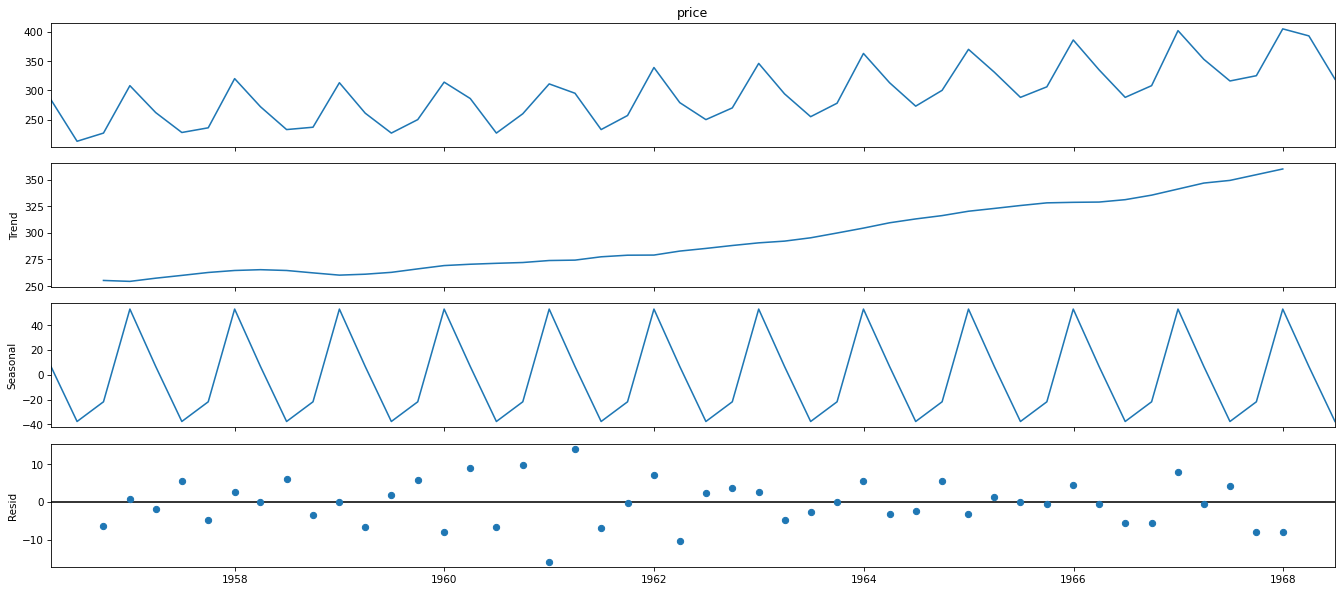

In [221]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_additive = seasonal_decompose(train1['price'][:50],model = "additive")
s_dec_additive.plot()
plt.show()

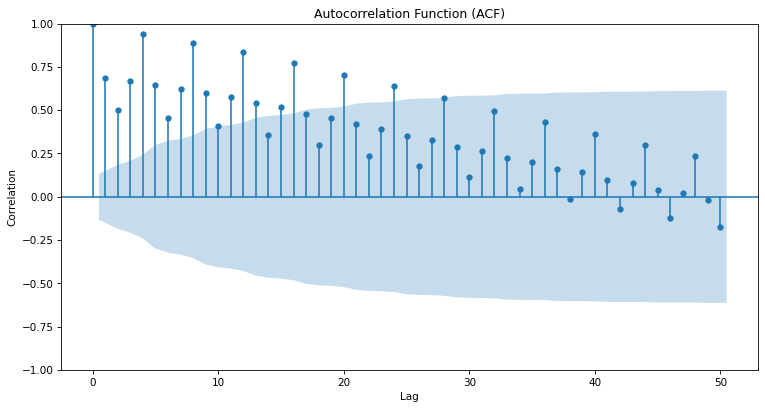

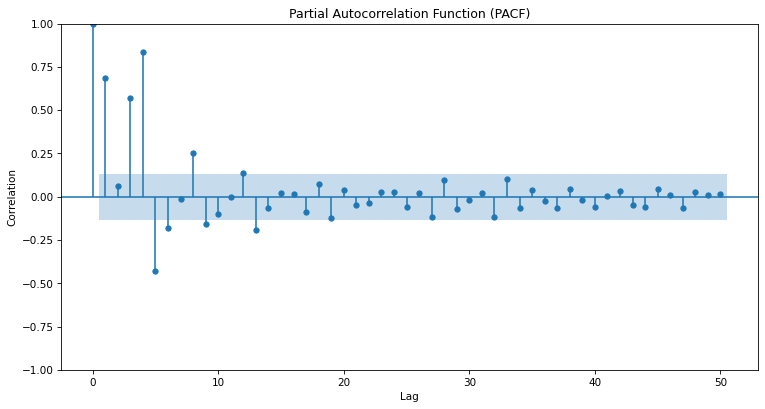

In [222]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(df['price'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(df['price'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()


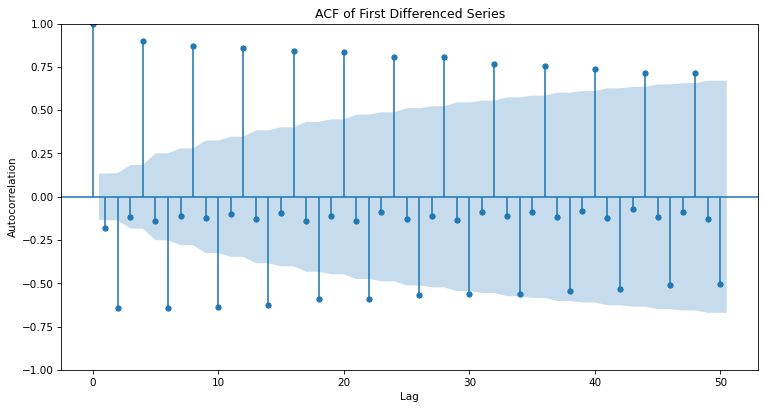

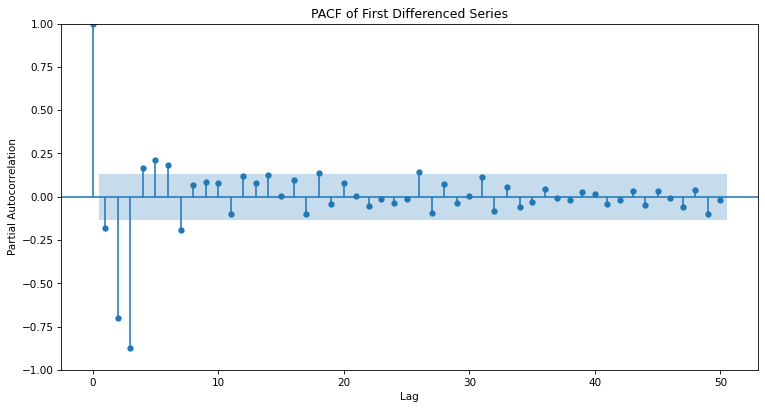

In [223]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute the first differenced series
first_differenced_series = np.log(df['price']).diff().dropna()

# ACF plot for first differenced series
plt.figure(figsize=(12, 6))
plot_acf(first_differenced_series, lags=50, ax=plt.gca())
plt.title('ACF of First Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# PACF plot for first differenced series
plt.figure(figsize=(12, 6))
plot_pacf(first_differenced_series, lags=50, ax=plt.gca())
plt.title('PACF of First Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


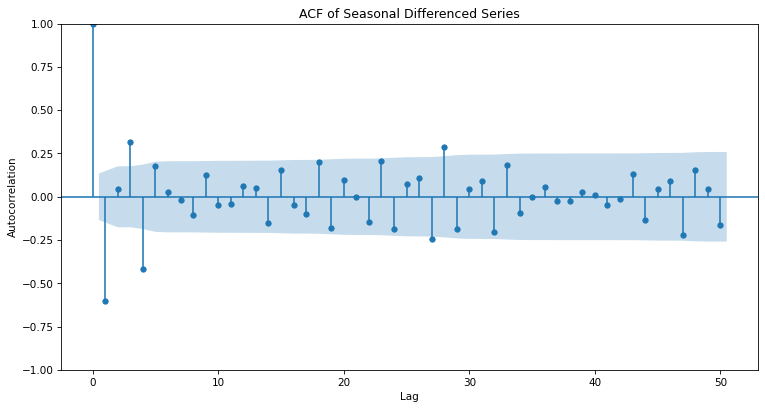

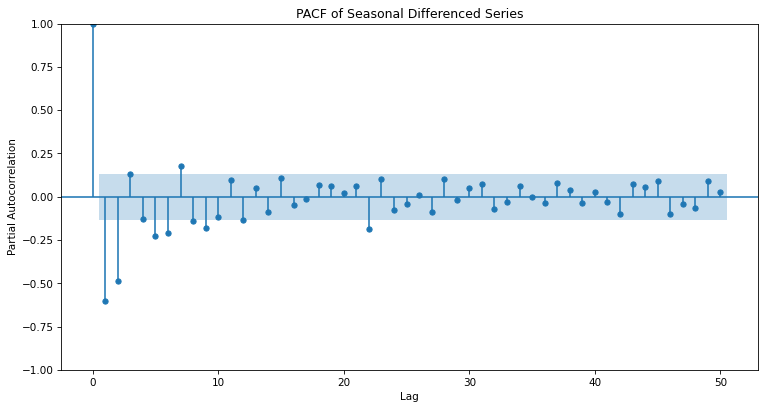

In [224]:
# Compute the second differenced series
second_differenced_series = first_differenced_series.diff(4).dropna()

# ACF plot for second differenced series
plt.figure(figsize=(12, 6))
plot_acf(second_differenced_series, lags=50, ax=plt.gca())
plt.title('ACF of Seasonal Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# PACF plot for second differenced series
plt.figure(figsize=(12, 6))
plot_pacf(second_differenced_series, lags=50, ax=plt.gca())
plt.title('PACF of Seasonal Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [225]:
# sudipta

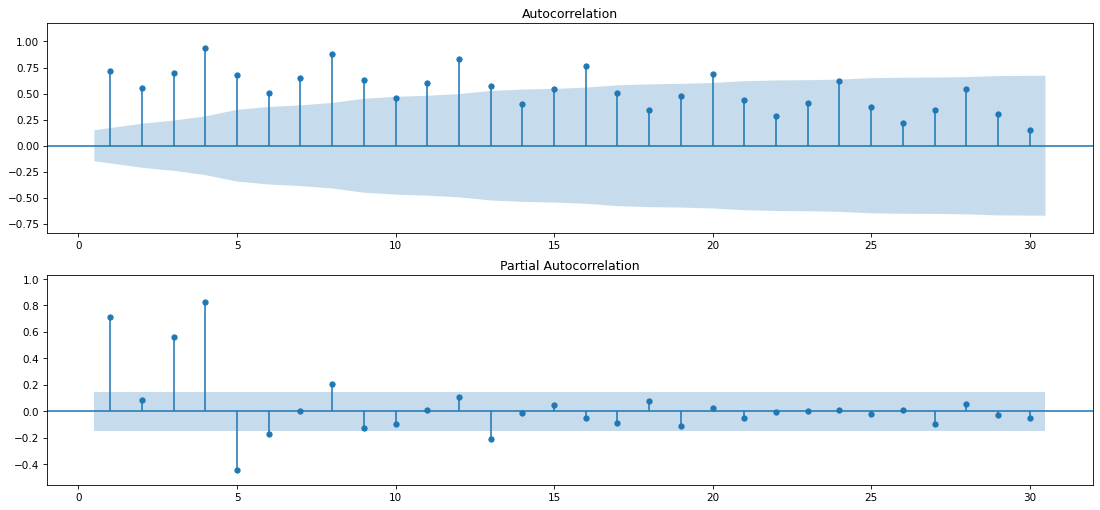

In [226]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(train1['price'], lags=30, ax=plt.gca(), alpha = 0.05, auto_ylims= True, zero = False)
plt.subplot(212)
plot_pacf(train1['price'], lags=30, ax=plt.gca(), alpha= 0.05, auto_ylims= True, zero = False,method = 'ywm')
plt.show()

In [227]:
diff1 = df.diff().dropna()

In [228]:
result = adfuller(diff1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.007879
p-value: 0.283129
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


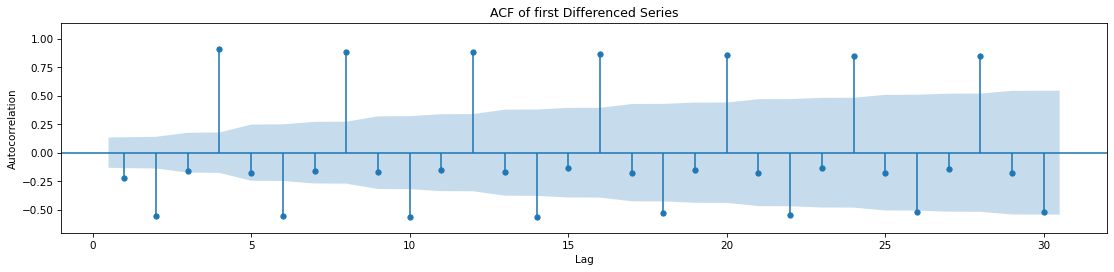

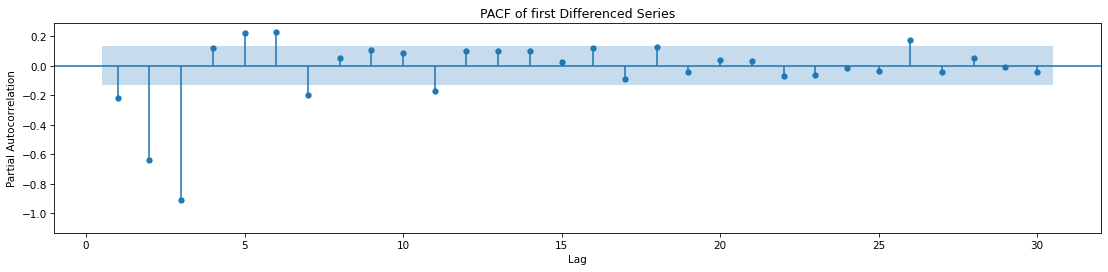

In [229]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff1, lags=30, ax=plt.gca(), alpha = 0.05, auto_ylims= True, zero = False, bartlett_confint=True)
plt.title('ACF of first Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


plt.subplot(212)
plot_pacf(diff1, lags=30, ax=plt.gca(), alpha = 0.05, auto_ylims= True, zero = False, method = 'ywm')
plt.title('PACF of first Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [230]:
diff4 = df.diff().diff(4).dropna()

In [231]:
result = adfuller(diff4)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.352906
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


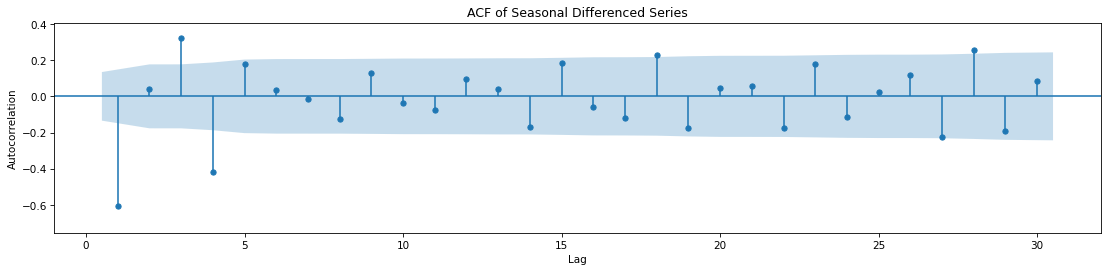

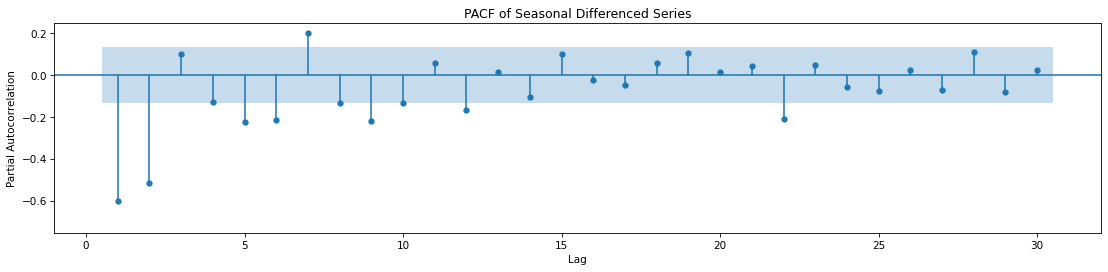

In [232]:
# ACF plot
plt.figure(figsize=(18, 8))
plt.subplot(211)
plot_acf(diff4, lags=30, ax=plt.gca(), alpha=0.05, auto_ylims=True, zero=False, bartlett_confint=True)
plt.title('ACF of Seasonal Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# PACF plot
plt.figure(figsize=(18, 8))
plt.subplot(212)
plot_pacf(diff4, lags=30, ax=plt.gca(), alpha=0.05, auto_ylims=True, zero=False, method='ywm')
plt.title('PACF of Seasonal Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


### So, d=1, D = 1 suggested

In [233]:
## Also ARIMA(3,1,2) can a choice

In [234]:
import statsmodels.tsa.statespace.sarimax as sarima

In [235]:
model1=sarima.SARIMAX(train1['price'],order=(3, 1, 2),trend = 'c',enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)

print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  174
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -726.260
Date:                Thu, 02 May 2024   AIC                           1466.521
Time:                        02:50:18   BIC                           1488.471
Sample:                    03-31-1956   HQIC                          1475.428
                         - 06-30-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1816      2.169      1.467      0.142      -1.069       7.433
ar.L1         -0.9009      0.038    -23.461      0.000      -0.976      -0.826
ar.L2         -1.0036      0.007   -144.315      0.0

In [236]:
model1.loglikelihood_burn

4

<Figure size 2250x525 with 0 Axes>

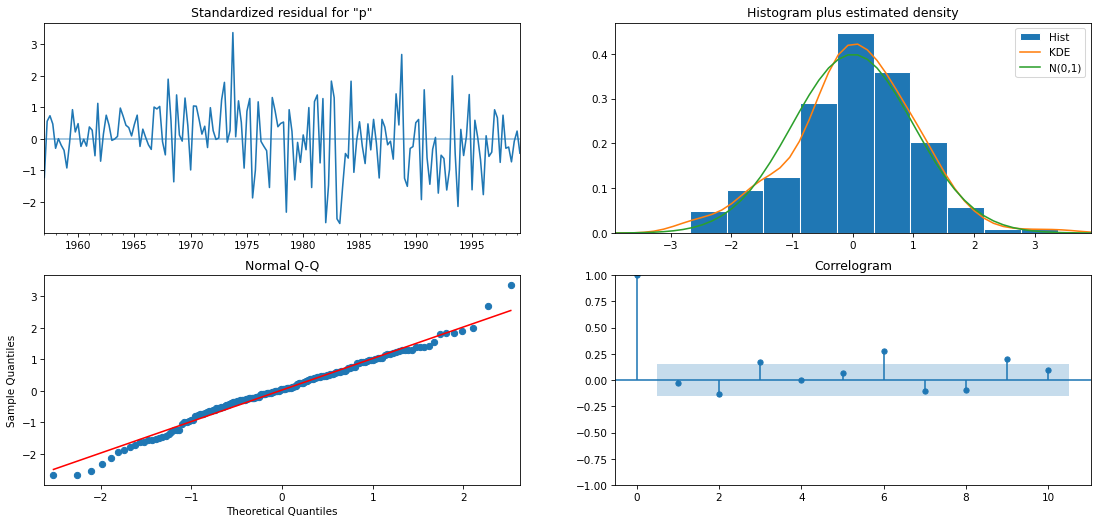

In [237]:
fig = plt.figure(figsize=(30,7))
fig = model1.plot_diagnostics()

In [238]:
from statsmodels.stats.diagnostic import acorr_ljungbox

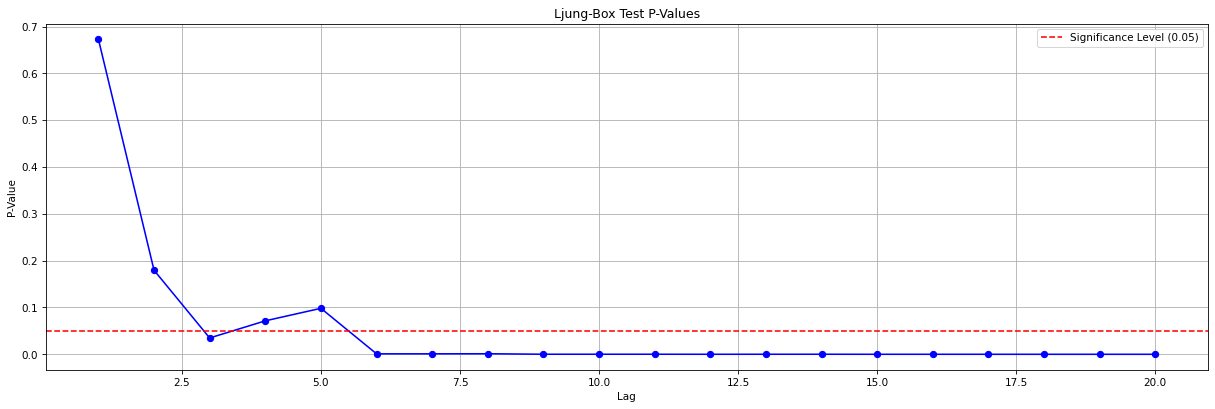

In [239]:
resid1 = model1.resid[4:]
max_lag = 20
lb1 = acorr_ljungbox(resid1, lags=max_lag)
lb_pvalue = lb1['lb_pvalue']
# Create a list of lag values
lag_values = np.arange(1, max_lag + 1)

# Plot the p-values against the lag values
plt.figure(figsize=(20, 6))
plt.plot(lag_values, lb_pvalue, marker='o', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-Value')
plt.title('Ljung-Box Test P-Values')
plt.legend()
plt.grid(True)
plt.show()

In [240]:
## Also ARIMA(3,1,3) can a choice

In [241]:
model2=sarima.SARIMAX(train1['price'],order=(3, 1, 3),trend = 'c',enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)

print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  174
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -720.591
Date:                Thu, 02 May 2024   AIC                           1457.182
Time:                        02:50:19   BIC                           1482.221
Sample:                    03-31-1956   HQIC                          1467.343
                         - 06-30-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4867      1.932      1.805      0.071      -0.300       7.273
ar.L1         -0.8563      0.048    -17.996      0.000      -0.950      -0.763
ar.L2         -1.0047      0.005   -222.365      0.0

In [242]:
model2.loglikelihood_burn

5

<Figure size 2250x525 with 0 Axes>

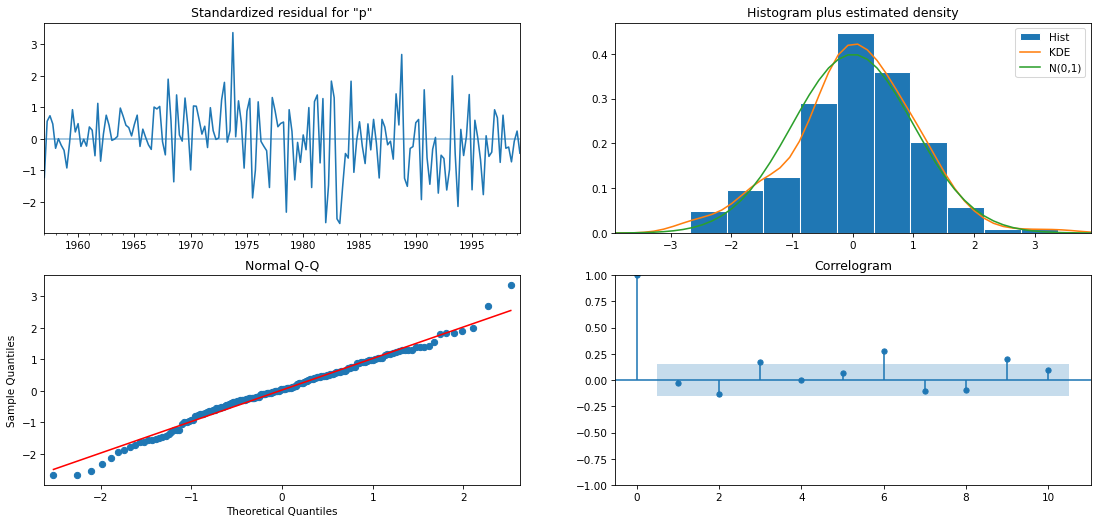

In [243]:
fig = plt.figure(figsize=(30,7))
fig = model1.plot_diagnostics()

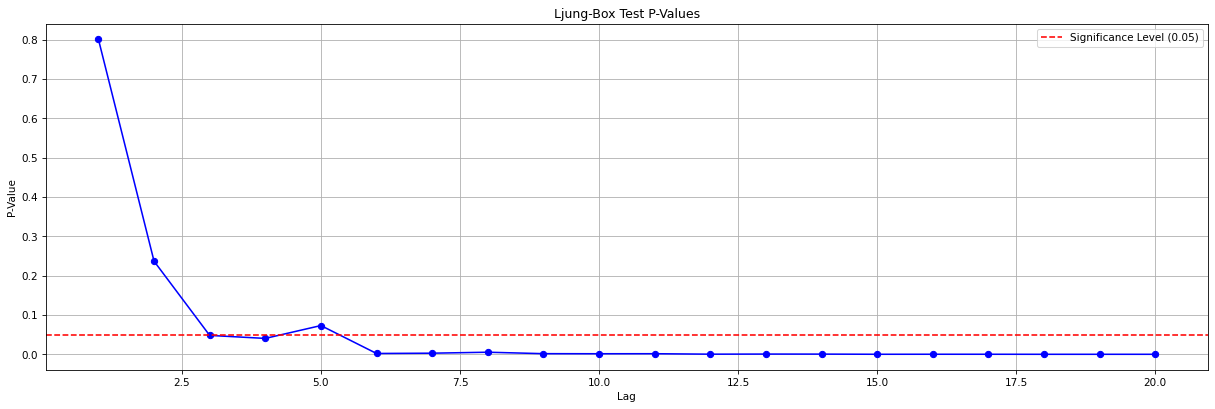

In [244]:
resid2 = model2.resid[4:]
max_lag = 20
lb1 = acorr_ljungbox(resid2, lags=max_lag)
lb_pvalue = lb1['lb_pvalue']
# Create a list of lag values
lag_values = np.arange(1, max_lag + 1)

# Plot the p-values against the lag values
plt.figure(figsize=(20, 6))
plt.plot(lag_values, lb_pvalue, marker='o', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-Value')
plt.title('Ljung-Box Test P-Values')
plt.legend()
plt.grid(True)
plt.show()

In [245]:
# Forecast future values with confidence intervals
forecast_steps = len(test1)
forecast_results = model2.get_forecast(steps=forecast_steps, alpha=0.05)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

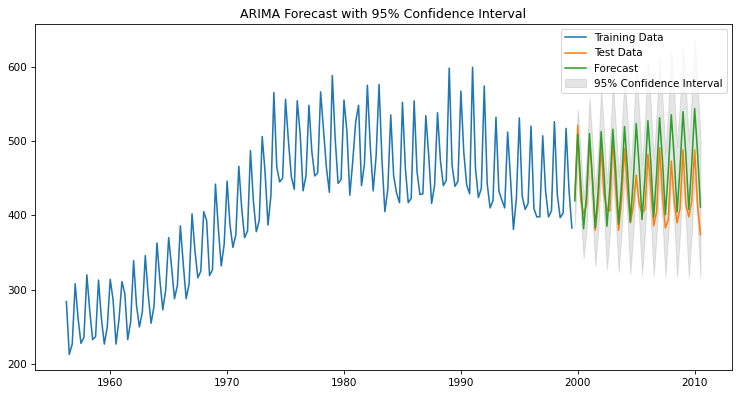

In [246]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train1.index, train1['price'], label='Training Data')
plt.plot(test1.index, test1['price'], label='Test Data')
plt.plot(test1.index, forecast, label='Forecast')
plt.fill_between(test1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.show()

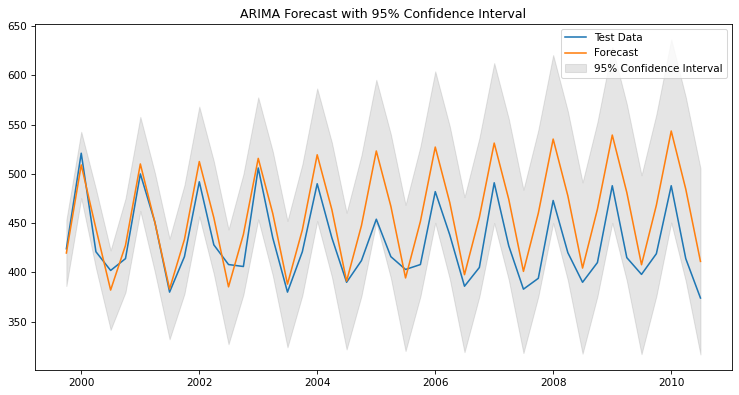

In [247]:
# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(train1.index, train1['price'], label='Training Data')
plt.plot(test1.index, test1['price'], label='Test Data')
plt.plot(test1.index, forecast, label='Forecast')
plt.fill_between(test1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.show()

In [248]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

x = test1['price']
y = forecast_df['Forecast']

# Calculate MSE
mse = mean_squared_error(x, y)

# Calculate MAPE
mape = mean_absolute_percentage_error(x, y)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", round(mape*100, 2),"%")

Mean Squared Error (MSE): 1405.3869321572079
Mean Absolute Percentage Error (MAPE): 7.31 %


In [249]:
test1

,price
date_quarter,
1999-09-30,424
1999-12-31,521
2000-03-31,421
2000-06-30,402
2000-09-30,414
2000-12-31,500
2001-03-31,451
2001-06-30,380
2001-09-30,416


In [250]:
import pandas as pd

# Output of the forecast
forecast_values = {
    'Date': forecast_results.predicted_mean.index,
    'Forecast': forecast_results.predicted_mean.values
}

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_values)

print(forecast_df)


         Date    Forecast
0  1999-09-30  419.715829
1  1999-12-31  509.128652
2  2000-03-31  444.565091
3  2000-06-30  382.089805
4  2000-09-30  427.447537
5  2000-12-31  510.101018
6  2001-03-31  450.689759
7  2001-06-30  383.200699
8  2001-09-30  433.457666
9  2001-12-31  512.545650
10 2002-03-31  455.554405
11 2002-06-30  385.384129
12 2002-09-30  438.555839
13 2002-12-31  515.771529
14 2003-03-31  459.748784
15 2003-06-30  388.136745
16 2003-09-30  443.171699
17 2003-12-31  519.411948
18 2004-03-31  463.585848
19 2004-06-30  391.191447
20 2004-09-30  447.533249
21 2004-12-31  523.272301
22 2005-03-31  467.231661
23 2005-06-30  394.406507
24 2005-09-30  451.761487
25 2005-12-31  527.249309
26 2006-03-31  470.774340
27 2006-06-30  397.706721
28 2006-09-30  455.920631
29 2006-12-31  531.288155
30 2007-03-31  474.260637
31 2007-06-30  401.052194
32 2007-09-30  460.044766
33 2007-12-31  535.359743
34 2008-03-31  477.715354
35 2008-06-30  404.421763
36 2008-09-30  464.151986
37 2008-12-3

In [251]:
# SARIMA

In [252]:
model_s1 = sarima.SARIMAX(train1['price'],
                        order=(3, 1, 3),
                        seasonal_order=(1, 1, 1, 4),
                        trend='c',
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=0)

print(model_s1.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                  174
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 4)   Log Likelihood                -669.488
Date:                             Thu, 02 May 2024   AIC                           1358.976
Time:                                     02:50:21   BIC                           1389.790
Sample:                                 03-31-1956   HQIC                          1371.487
                                      - 06-30-1999                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2568      0.398     -0.645      0.519      -1.038       0.524
ar.L1         -1.3423      

In [253]:
model_s2 = sarima.SARIMAX(train1['price'],
                        order=(3, 1, 3),
                        seasonal_order=(0, 1, 2, 4),
                        trend='c',
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=0)

print(model_s2.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                  price   No. Observations:                  174
Model:             SARIMAX(3, 1, 3)x(0, 1, [1, 2], 4)   Log Likelihood                -652.363
Date:                                Thu, 02 May 2024   AIC                           1324.726
Time:                                        02:50:21   BIC                           1355.288
Sample:                                    03-31-1956   HQIC                          1337.138
                                         - 06-30-1999                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3049      0.467     -0.654      0.513      -1.219       0.610
ar.

In [254]:
model_s2.loglikelihood_burn

17

<Figure size 2250x525 with 0 Axes>

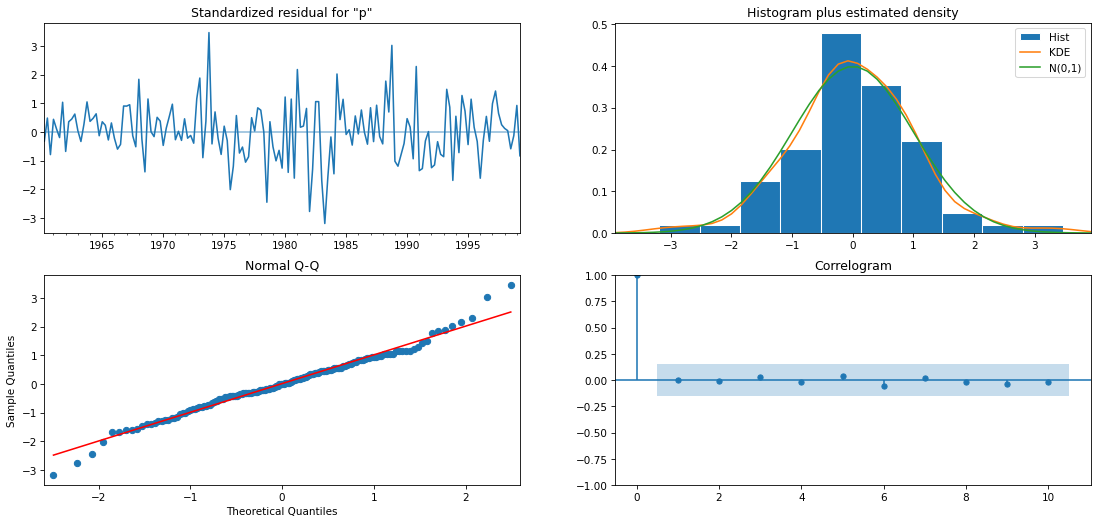

In [255]:
fig = plt.figure(figsize=(30,7))
fig = model_s2.plot_diagnostics()

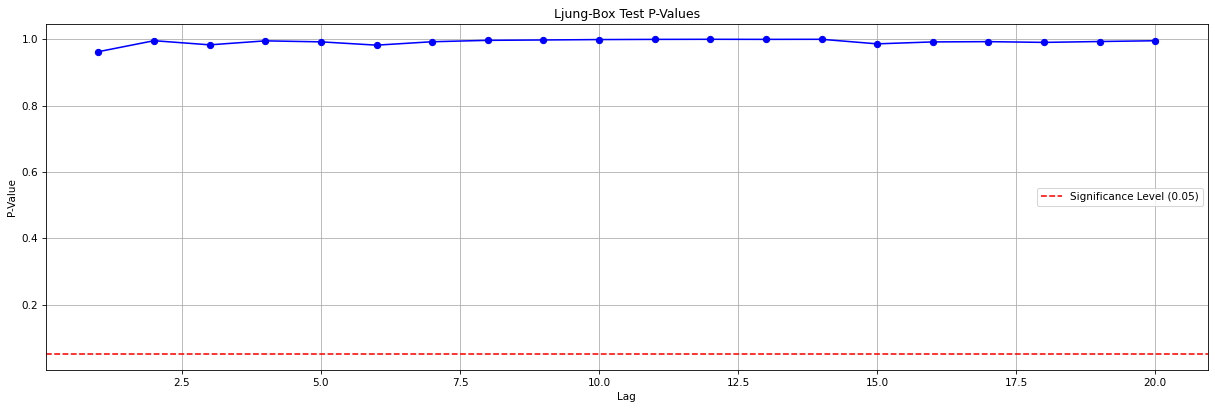

In [256]:
resid2 = model_s2.resid[17:]
max_lag = 20
lb1 = acorr_ljungbox(resid2, lags=max_lag)
lb_pvalue = lb1['lb_pvalue']
# Create a list of lag values
lag_values = np.arange(1, max_lag + 1)

# Plot the p-values against the lag values
plt.figure(figsize=(20, 6))
plt.plot(lag_values, lb_pvalue, marker='o', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-Value')
plt.title('Ljung-Box Test P-Values')
plt.legend()
plt.grid(True)
plt.show()

In [257]:
# Forecast future values with confidence intervals
forecast_steps = len(test1)
forecast_results = model_s2.get_forecast(steps=forecast_steps, alpha=0.05)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

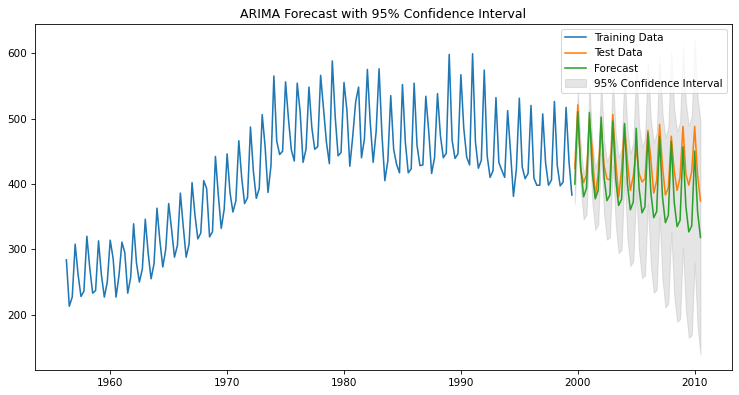

In [258]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train1.index, train1['price'], label='Training Data')
plt.plot(test1.index, test1['price'], label='Test Data')
plt.plot(test1.index, forecast, label='Forecast')
plt.fill_between(test1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.show()

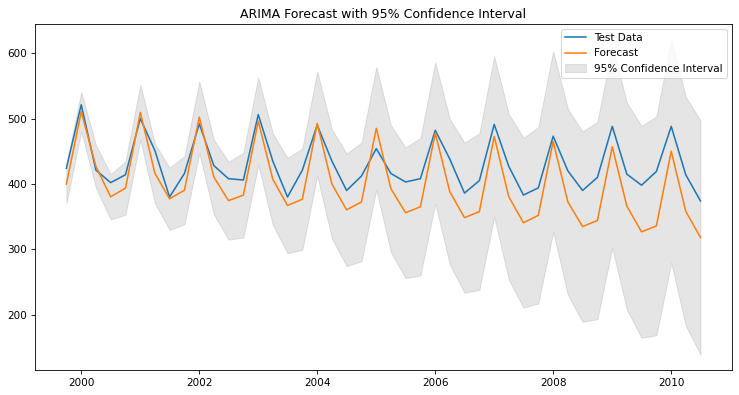

In [259]:
# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(train1.index, train1['price'], label='Training Data')
plt.plot(test1.index, test1['price'], label='Test Data')
plt.plot(test1.index, forecast, label='Forecast')
plt.fill_between(test1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.show()

In [260]:
import pandas as pd

# Output of the forecast
forecast_values = {
    'Date': forecast_results.predicted_mean.index,
    'Forecast': forecast_results.predicted_mean.values
}

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_values)

print(forecast_df)


         Date    Forecast
0  1999-09-30  399.814025
1  1999-12-31  510.429544
2  2000-03-31  426.725299
3  2000-06-30  380.326954
4  2000-09-30  393.570176
5  2000-12-31  509.340667
6  2001-03-31  416.310987
7  2001-06-30  377.229039
8  2001-09-30  390.372352
9  2001-12-31  502.159045
10 2002-03-31  410.489493
11 2002-06-30  374.428343
12 2002-09-30  382.964005
13 2002-12-31  496.096657
14 2003-03-31  407.240890
15 2003-06-30  367.058472
16 2003-09-30  376.582275
17 2003-12-31  492.440041
18 2004-03-31  399.871321
19 2004-06-30  360.381432
20 2004-09-30  372.522121
21 2004-12-31  485.047044
22 2005-03-31  392.915961
23 2005-06-30  355.924496
24 2005-09-30  365.083245
25 2005-12-31  477.828108
26 2006-03-31  388.069519
27 2006-06-30  348.419052
28 2006-09-30  357.613295
29 2006-12-31  472.599841
30 2007-03-31  380.478482
31 2007-06-30  340.708706
32 2007-09-30  352.011144
33 2007-12-31  464.905774
34 2008-03-31  372.536626
35 2008-06-30  334.740739
36 2008-09-30  344.198117
37 2008-12-3

In [261]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

x = test1['price']
y = forecast_df['Forecast']

# Calculate MSE
mse = mean_squared_error(x, y)

# Calculate MAPE
mape = mean_absolute_percentage_error(x, y)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", round(mape*100, 2),"%")

Mean Squared Error (MSE): 1427.8832585608397
Mean Absolute Percentage Error (MAPE): 7.82 %


In [263]:
import itertools

# Define non-seasonal order
p = 3
d = 1
q = 3

# Define range of values for seasonal order
seasonal_p_values = [0, 1, 2]
seasonal_q_values = [0, 1, 2]
seasonal_d = 1
s = 4  # Seasonal period

# Create a list of all possible combinations of seasonal order parameters
seasonal_orders = list(itertools.product(seasonal_p_values, [seasonal_d], seasonal_q_values, [s]))

# Loop through each combination and fit SARIMA model
for seasonal_order in seasonal_orders:
    model = sarima.SARIMAX(train1['price'],
                           order=(p, d, q),
                           seasonal_order=seasonal_order,
                           trend='c',
                           enforce_stationarity=False,
                           enforce_invertibility=False).fit(disp=0)
    
    print(f"Seasonal Order: {seasonal_order}, AIC: {model.aic}")
    print(model.summary())


Seasonal Order: (0, 1, 0, 4), AIC: 1403.1419313976462
                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  174
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 4)   Log Likelihood                -693.571
Date:                            Thu, 02 May 2024   AIC                           1403.142
Time:                                    02:56:22   BIC                           1427.989
Sample:                                03-31-1956   HQIC                          1413.228
                                     - 06-30-1999                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1453      0.049     -2.958      0.003      